## Introduction

This notebook is the same as the others but here deep neural network is used to calculate the photometric redshift. I use the same dataset used in determining_redshift_less_bias.

In [19]:
import os
import numpy as np
import pandas as pd
from pandas.plotting import table
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
sns.set()
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense
import scikeras
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

In [2]:
#Loading files
filepath= "/home/veroastro/Documents/spectraTypes/MLphotometry/data/"
galaxy = pd.read_csv(filepath+"galaxy_nophotoZ4.csv")
star = pd.read_csv(filepath+"star_nophotoZ.csv")
QSO = pd.read_csv(filepath+"QSO_nophotoZ.csv")
#Create the data frame from the three sets of data
data = pd.concat([star, QSO, galaxy])
#Scramble the data set so that it is not ordered by spectral class (QSO, galaxy or star) 
data = data.sample(frac=1)

data.describe()

,objID,type,dered_u,err_u,dered_g,err_g,dered_r,err_r,dered_i,err_i,dered_z,err_z,z,zErr,zWarning
count,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,1.500000e+04,1.500000e+04,15000.0
mean,1.237663e+18,4.929000,19.278773,0.042984,18.242983,0.009593,17.803544,0.009490,17.590448,0.010945,17.445029,0.029899,5.338676e-01,1.237876e-04,0.0
std,7.483467e+12,1.437392,1.073886,0.023426,1.280207,0.005298,1.444430,0.006185,1.521226,0.007890,1.569711,0.025342,8.067329e-01,3.004838e-04,0.0
min,1.237646e+18,3.000000,7.552934,0.003263,7.661058,0.000773,8.319589,0.000540,10.746470,0.000361,8.741409,0.001826,5.417808e-09,2.446185e-07,0.0
25%,1.237658e+18,3.000000,18.716025,0.023869,17.467247,0.005797,16.804580,0.005041,16.486115,0.005232,16.265550,0.010507,3.022298e-04,1.047030e-05,0.0
50%,1.237662e+18,6.000000,19.425340,0.039461,18.242070,0.008259,17.639700,0.007119,17.365905,0.007650,17.256925,0.019170,8.968894e-02,2.082942e-05,0.0
75%,1.237667e+18,6.000000,20.037327,0.059336,19.222772,0.011863,19.024073,0.012156,18.929403,0.014503,18.864542,0.042937,9.271685e-01,1.645424e-04,0.0
max,1.237681e+18,6.000000,21.546420,0.099982,22.145940,0.089225,21.324990,0.077705,21.340340,0.087281,20.616610,0.099979,6.164721e+00,2.278432e-02,0.0


In [5]:
# Removing Id, error and class data
data_clean = data.drop(columns=['objID','err_u', 'err_g', 'err_r', 'err_i', 'err_z', 'zErr', 'class', 'subClass', 'type', 'zWarning'])
data_clean.head()

,dered_u,dered_g,dered_r,dered_i,dered_z,z
3587,20.46667,19.35522,19.11573,18.89050,19.10108,0.000025
2180,19.53582,19.30467,19.30334,19.14516,19.23047,1.574018
2939,19.80314,19.11404,18.80314,18.34827,18.25025,1.551708
1965,17.44198,16.40174,16.14890,16.05972,16.06948,0.000134
4271,20.77851,20.47066,20.02573,19.90632,19.59271,0.364917


In [6]:
def hist_plots( data: pd.DataFrame,
               rows: int,
              cols: int,
              figsize: tuple):
    fig, axes = plt.subplots(rows,cols, figsize=figsize)
    for i, ax in enumerate(axes.flatten()):
        if i < len(data.columns):
            data[sorted(data.columns)[i]].plot.hist(bins=30, ax=ax)
            ax.set_title(f'{sorted(data.columns)[i]} distribution', fontsize=10)
            ax.tick_params(axis='x', labelsize=10)
            ax.tick_params(axis='y', labelsize=10)
            ax.get_yaxis().get_label().set_visible(False)
        else:
            fig.delaxes(ax=ax)
    fig.tight_layout()

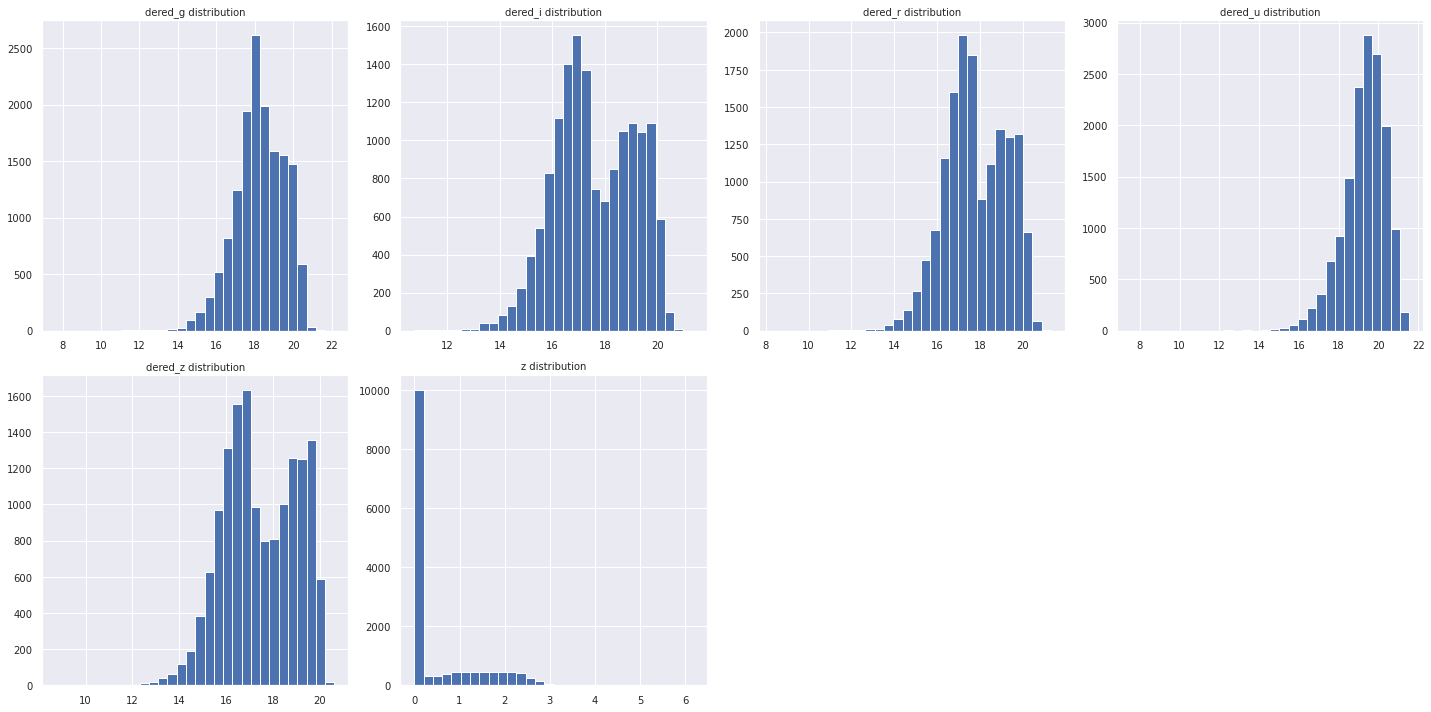

In [7]:
# Histogram of the columns in data_clean
hist_plots(data=data_clean,
          rows=2,
          cols=4,
          figsize=(20,10))

In [6]:
data_clean.describe()

,dered_u,dered_g,dered_r,dered_i,dered_z,z
count,135000.000000,135000.000000,135000.000000,135000.000000,135000.000000,135000.000000
mean,21.818135,20.309045,19.285139,18.592777,18.275074,0.293436
std,2.191509,1.830998,1.673204,1.488666,1.500261,0.498651
min,10.332040,9.884518,9.321852,9.207663,9.800303,-0.009944
25%,20.000940,18.970020,18.255080,17.759570,17.433850,0.000095
50%,21.933740,20.637290,19.579080,18.846650,18.440160,0.188444
75%,23.402515,21.611540,20.441560,19.561500,19.151623,0.431413
max,32.564690,31.013640,31.521720,31.343010,30.781270,7.018627


The data is not scaled because the input values are the 5 bands and their range is similar. 
In the cell bellow there are 2 sets of X and y. This is because the full dataset has 135000 points and it takes too long for the code to run so I reduced the dataset to 1% of the full dataset to help speed up tuning the DNN.

In [9]:
# creating the features and label dataframes and normalising X
from sklearn.preprocessing import RobustScaler
X = data_clean.drop(['z'], axis=1)
y = data_clean['z']
scaler = RobustScaler()
X_t = scaler.fit_transform(X)

In [50]:
# divide the X and y dataframsn into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_t, y, 
                                                    test_size=0.3, random_state=42)


In [91]:
from sklearn.model_selection import GridSearchCV
from keras.initializers import glorot_uniform
initializer = glorot_uniform(seed=42)

def create_model(alpha=0.01):
    model = Sequential()
    model.add(Dense(250, input_dim=5))
    model.add(LeakyReLU(alpha=alpha))
    model.add(Dense(50))
    model.add(LeakyReLU(alpha=alpha))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = KerasRegressor(model=create_model, epochs=100, batch_size=5, verbose=0)

param_grid = {'alpha': [ 0.075, 0.1, 1.0]}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


ValueError: Invalid parameter alpha for estimator KerasRegressor.
This issue can likely be resolved by setting this parameter in the KerasRegressor constructor:
`KerasRegressor(alpha=0.075)`
Check the list of available parameters with `estimator.get_params().keys()`

In [96]:
from keras.layers import LeakyReLU
initializer = 'glorot_uniform'

# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(250, input_dim=5, kernel_initializer=initializer))#, activation=act))
    model.add(LeakyReLU(alpha=1))
    model.add(Dense(50, kernel_initializer=initializer))#, activation=act))
    model.add(LeakyReLU(alpha=1))
    model.add(Dense(1, kernel_initializer=initializer))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

Tried adding new layers but the mse of the test sample went from 0.081(mse of current setting) to 0.129. Increasing the number of nodes give an mse of 0.085. 


In [97]:
estimator = KerasRegressor(model=baseline_model, epochs=100, batch_size=5, verbose=0)

In [98]:
# fit the model and make predictions
estimator.fit(X_train, y_train)
predictions = estimator.predict(X_test)

In [99]:
# print mean square errors between predicted and spectroscopic z
from sklearn.metrics import mean_squared_error
pred_err = abs(predictions - y_test)
print('Mean Square Error:', round(mean_squared_error(y_test,predictions), 3))

Mean Square Error: 0.315


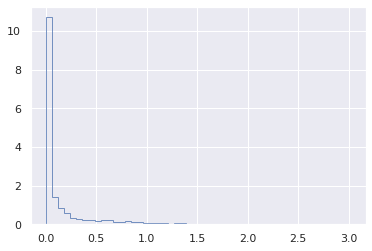

In [39]:
#handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in [low,medium, high]]# histogram of the predicted errors and the SDSS errors
plt.hist(pred_err, bins=50, alpha=0.75, density = True ,histtype= 'step')
plt.show()

# Adding colours

In [41]:
# Create a function to calculate the colours of the sources
def compute_colour(row):
    u = row['dered_u']
    g = row['dered_g']
    r = row['dered_r']
    i = row['dered_i']
    z = row['dered_z']
    return pd.Series({'u-g': u - g, 'g-r': g - r, 'r-i': r - i, 'i-z': i - z})
# Apply the function compute_colour
colour_ind = data_clean.apply(compute_colour, axis=1)
# Create new dataframe with the colours added
data_colour = pd.concat([data_clean,colour_ind], axis=1)
data_colour.describe()

,dered_u,dered_g,dered_r,dered_i,dered_z,z,u-g,g-r,r-i,i-z
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000
mean,19.278773,18.242983,17.803544,17.590448,17.445029,5.338676e-01,1.035791,0.439438,0.213096,0.145420
std,1.073886,1.280207,1.444430,1.521226,1.569711,8.067329e-01,0.647352,0.350960,0.196789,0.171565
min,7.552934,7.661058,8.319589,10.746470,8.741409,5.417808e-09,-1.391450,-1.454840,-3.861471,-1.146380
25%,18.716025,17.467247,16.804580,16.486115,16.265550,3.022298e-04,0.465475,0.174497,0.087350,0.027745
50%,19.425340,18.242070,17.639700,17.365905,17.256925,8.968894e-02,1.048255,0.382455,0.202605,0.133620
75%,20.037327,19.222772,19.024073,18.929403,18.864542,9.271685e-01,1.506298,0.715958,0.372275,0.273913
max,21.546420,22.145940,21.324990,21.340340,20.616610,6.164721e+00,3.653620,3.852890,1.688770,3.762850


In [56]:
X_c = data_colour.drop(['z'], axis=1)
y_c = data_colour['z']
X_t_c = scaler.fit_transform(X_c)
X_scaled_c = pd.DataFrame(X_t_c, columns = X_c.columns)
X_c_train, X_c_test, y_c_train, y_c_test = train_test_split(X_scaled_c, y_c, 
                                                    test_size=0.3, random_state=42)


In [67]:
# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(250, input_dim=9, kernel_initializer=initializer, activation='relu'))
    model.add(Dense(50, kernel_initializer=initializer, activation='relu'))
    model.add(Dense(1, kernel_initializer=initializer))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [68]:
estimator2 = KerasRegressor(model=baseline_model, epochs=100, batch_size=5, verbose=0)
# fit the model and make predictions
estimator2.fit(X_c_train, y_c_train)
predictions2 = estimator2.predict(X_c_test)

In [69]:
pred_err_C = abs(predictions2 - y_c_test)
print('Mean Square Error:', round(mean_squared_error(y_c_test,predictions2), 3))

Mean Square Error: 0.13


## Conlusion

The DNN pred_err is 0.184 and the SDSS photometric error is 0.259. This is an order of magnitude bigger than the spectroscopic error of 0.07. The DNN pred_err does 29% better than the SDSS photometric redshift but both show some catastrophic error of > 1 but the numbers of sources with such errors is almost irrelevant with respect to the number of sources in the dataset. 